In [1]:
import librosa
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import IPython.display as ipd
import music21 as m21
import sys
import IPython
from IPython.core.display import display, HTML, Javascript
import json, random

In [2]:
import keras
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l1, l2
from livelossplot import PlotLossesKeras

Using TensorFlow backend.


Testing segmentation and starting a pipeline. This notebook is mainly tests.

In [3]:
ipd.Audio("../Samples/Guitar/Riffs/Guitar_noamp_riff1.mp3")

In [4]:
y, sr = librosa.load("../Samples/Guitar/Riffs/Guitar_noamp_riff1.mp3", mono=False)
y = librosa.core.to_mono(y)
y = librosa.resample(y, sr, 8000)

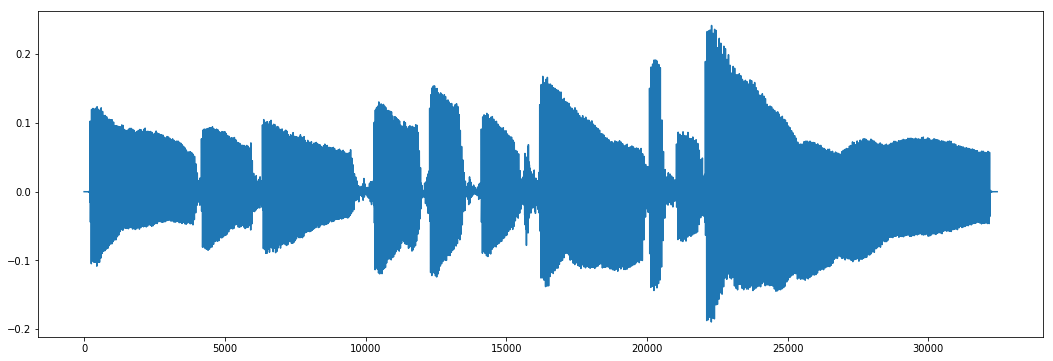

In [5]:
plt.figure(figsize=(18,6))
plt.plot(y)

In [6]:
onset_frames = librosa.onset.onset_detect(y=y, sr=sr, units="samples", hop_length=50, backtrack=True)

In [7]:
onset_frames

array([ 4050,  5800,  9500, 11950, 15500, 19900, 22150, 32100])

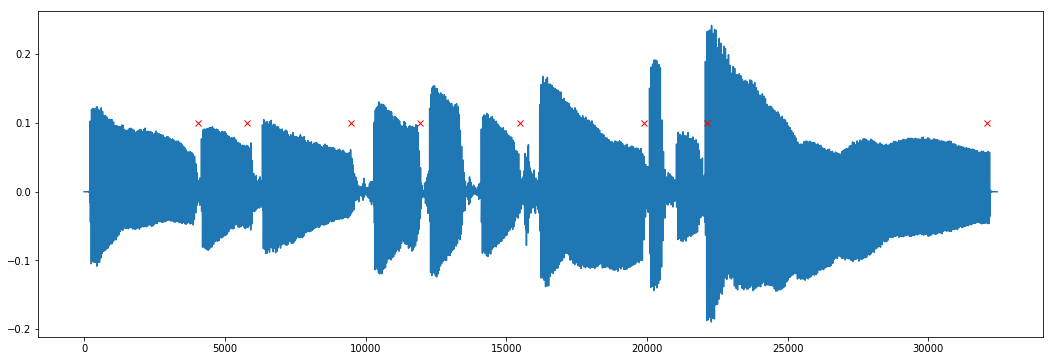

In [8]:
plt.figure(figsize=(18,6))
plt.plot(y)
plt.plot(onset_frames, [0.1]*len(onset_frames), 'rx')

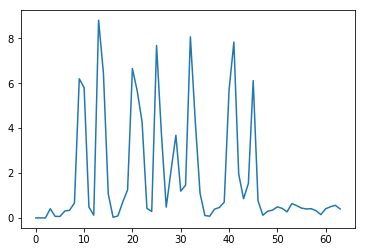

In [9]:
plt.plot(librosa.onset.onset_strength(y, sr))

In [10]:
def envelope(y, n):
    env_pos = []
    env_neg = []

    for i in range(0, len(y), n):
        env_pos += n * [np.max(y[i:(n+i)])]
        env_neg += n * [np.min(y[i:(n+i)])]
        
    return env_pos, env_neg

In [11]:
env_pos, env_neg = envelope(y, 100)

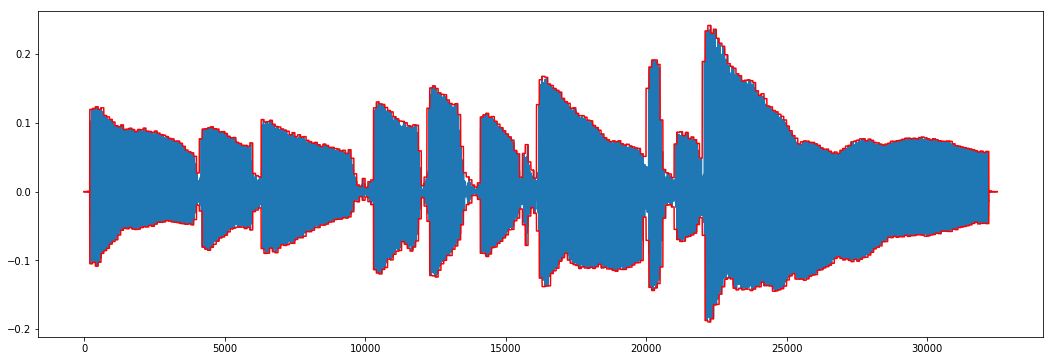

In [12]:
plt.figure(figsize=(18,6))
plt.plot(y)
plt.plot(env_pos, 'r')
plt.plot(env_neg, 'r')

In [13]:
def frontiers(y, env, k):
    previous = np.array(env)[:-1]
    next = np.array(env)[1:]
    front = np.argwhere((next >= k*previous) & (next > 0.025)).flatten()
    front = np.append(front, len(y[::-1][np.argwhere(y[::-1] >= 0.005)[0][0]:]))
    
    return front

In [14]:
front = frontiers(y, env_pos, 2)
len(front)

12

In [15]:
front

array([  199,  4099,  6299, 10299, 12199, 14099, 15599, 16099, 19999,
       20999, 21999, 32180], dtype=int64)

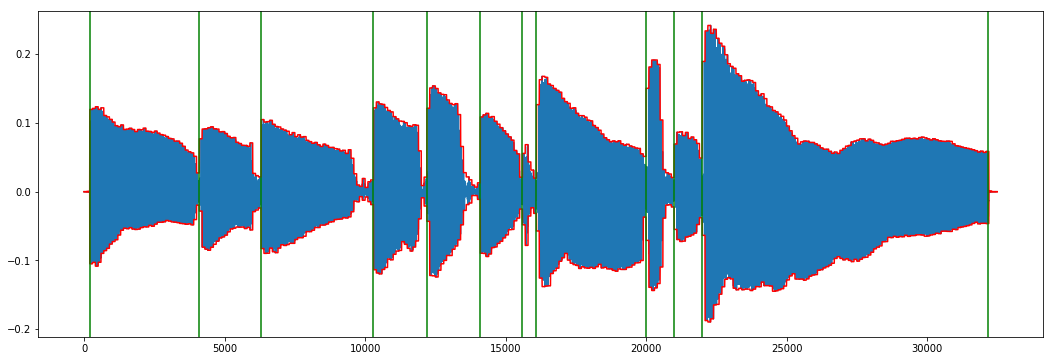

In [16]:
plt.figure(figsize=(18,6))
plt.plot(y)
plt.plot(env_pos, 'r')
plt.plot(env_neg, 'r')
for i in front:
    plt.axvline(x=i, color="g")

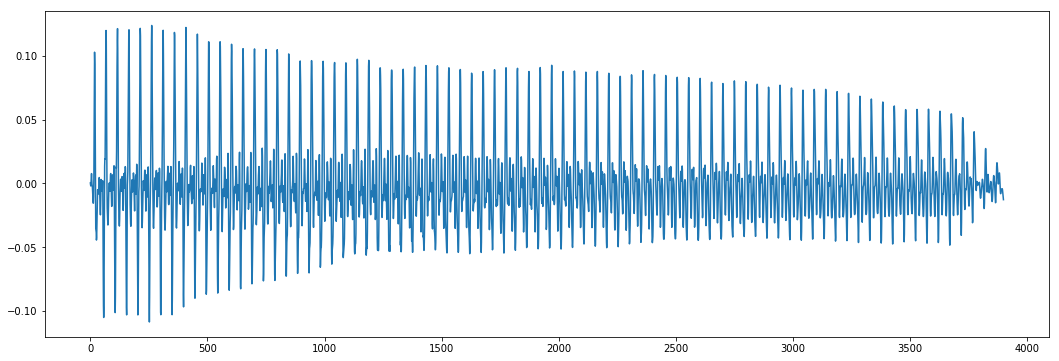

In [17]:
note_0 = y[front[0]:front[1]]
plt.figure(figsize=(18,6))
plt.plot(note_0)

In [18]:
note_0_data = pd.DataFrame({'x{}'.format(i): [note_0[i]] for i in range(500)})
note_0_data

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x490,x491,x492,x493,x494,x495,x496,x497,x498,x499
0,0.000422,-0.001165,-0.00195,0.00108,0.005519,0.007724,0.003928,-0.000589,-0.001745,-0.003886,...,0.010652,0.020023,0.00656,-0.031573,-0.069176,-0.086558,-0.083763,-0.066905,-0.045872,-0.030751


In [19]:
import json
from keras.models import model_from_json

def load_NN(name):
    with open(name + "_NN_architecture.json", 'r') as json_file:
        model = model_from_json(json_file.read())
    model.load_weights(name + "_NN_weights.h5")
    model.summary()
    return model

In [20]:
import json
from keras.models import model_from_json

with open("../Single_note_models/Guitar/Guitar_NN_architecture.json", 'r') as json_file:
    model = model_from_json(json_file.read())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [21]:
model.load_weights("../Single_note_models/Guitar/Guitar_NN_weights.h5")

In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 500)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               128256    
_________________________________________________________________
dense_17 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 61)                7869      
Total params: 169,021
Trainable params: 169,021
Non-trainable params: 0
_________________________________________________________________


In [23]:
prediction = np.argmax(model.predict(note_0_data))

In [24]:
librosa.midi_to_note(prediction + 28)

'E3'

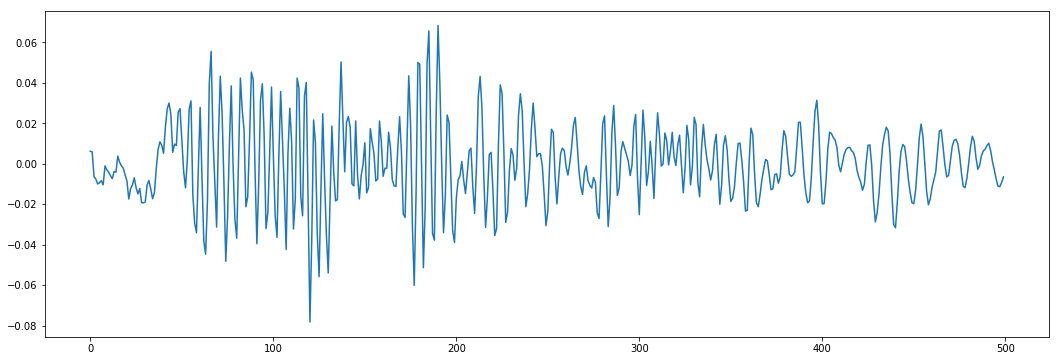

In [25]:
note_6 = y[front[6]:front[7]]
plt.figure(figsize=(18,6))
plt.plot(note_6)

In [26]:
note_6_data = pd.DataFrame({'x{}'.format(i): [note_6[i]] for i in range(500)})
note_6_data

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x490,x491,x492,x493,x494,x495,x496,x497,x498,x499
0,0.006248,0.005932,-0.006249,-0.007475,-0.009902,-0.009303,-0.008278,-0.010351,-0.000984,-0.002936,...,0.009105,0.0102,0.006621,0.001132,-0.002939,-0.007419,-0.010964,-0.011209,-0.0092,-0.006394


In [27]:
prediction = np.argmax(model.predict(note_6_data))

In [28]:
librosa.midi_to_note(prediction + 28)

'G#4'

In [29]:
model.predict(note_6_data)

array([[0.00762671, 0.00783208, 0.00752427, 0.00734732, 0.00513111,
        0.00567563, 0.00569574, 0.00572248, 0.00471218, 0.00527171,
        0.00559021, 0.00563537, 0.00409673, 0.00683859, 0.00666143,
        0.00529666, 0.00572044, 0.00911517, 0.00736107, 0.00581763,
        0.00809783, 0.00809005, 0.01323337, 0.01664451, 0.01003343,
        0.01166273, 0.01467254, 0.00905927, 0.01386907, 0.00854052,
        0.01154933, 0.01073653, 0.010761  , 0.01678565, 0.01201693,
        0.0165902 , 0.0278728 , 0.01946286, 0.04940131, 0.01895986,
        0.05812924, 0.02677386, 0.02498686, 0.01877519, 0.01552874,
        0.02000443, 0.01233493, 0.02827105, 0.02335835, 0.02359431,
        0.02073339, 0.01243992, 0.03449736, 0.02354458, 0.01745073,
        0.01151298, 0.02598602, 0.04283759, 0.0264762 , 0.05182464,
        0.04822735]], dtype=float32)

In [30]:
model.predict(note_0_data)

array([[8.6475639e-03, 4.8855338e-03, 1.1466364e-03, 8.5828663e-04,
        2.4221800e-03, 2.5262564e-02, 6.2031164e-03, 1.6507689e-03,
        1.5191030e-03, 3.2568267e-03, 1.1934235e-03, 2.4742391e-03,
        2.0668687e-02, 5.1507954e-03, 1.4072187e-03, 2.0870322e-03,
        2.7317149e-04, 1.1782307e-02, 1.2313145e-04, 1.6586711e-04,
        1.9482530e-04, 3.3124135e-05, 1.0446324e-04, 1.2097359e-02,
        8.5046756e-01, 8.0789393e-03, 1.2758344e-03, 2.4742556e-03,
        2.1257417e-04, 1.3671248e-04, 6.3001404e-05, 4.6866154e-03,
        6.9655076e-04, 9.4620191e-06, 8.5128297e-05, 1.5477864e-04,
        4.4682352e-03, 1.1107525e-04, 1.6005027e-04, 3.1620087e-03,
        9.2563105e-06, 9.6036028e-06, 3.1671921e-06, 9.7740162e-03,
        6.0206552e-05, 3.4460520e-08, 1.8578796e-05, 2.1771581e-05,
        3.2670437e-06, 2.9651054e-07, 4.6726422e-05, 8.6401560e-06,
        2.3709940e-07, 1.1564812e-06, 1.0573266e-05, 9.5643605e-05,
        1.3044555e-05, 1.2023322e-06, 4.0265903e

In [31]:
model.predict(note_6_data).max(), model.predict(note_0_data).max()

(0.058129244, 0.85046756)

In [32]:
string_model = load_NN("../Single_note_models/Guitar/Guitar_string")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 500)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               128256    
_________________________________________________________________
dense_8 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 61)                7869      
Total params: 169,021
Trainable params: 169,021
Non-trainable params: 0
_________________________________________________________________


In [33]:
norm_string_model = load_NN("../Single_note_models/Guitar/Guitar_norm_string")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 500)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               128256    
_________________________________________________________________
dense_10 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 61)                7869      
Total params: 169,021
Trainable params: 169,021
Non-trainable params: 0
_________________________________________________________________


In [39]:
fret_model = load_NN("../Single_note_models/Guitar/Guitar_fret_spectral")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 500)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               64128     
_________________________________________________________________
dense_18 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_19 (Dense)             (None, 200)               13000     
Total params: 85,384
Trainable params: 85,384
Non-trainable params: 0
_________________________________________________________________


In [34]:
def round_dur(x, base):
    return base * round(x/base)

In [43]:
note_table = pd.read_csv("../Data/Piano/Note_table.tsv", header=0, sep="\t")

In [44]:
start_8 = note_table[note_table["Note"] == "E1"].index[0]
start_7 = note_table[note_table["Note"] == "B1"].index[0]
start_6 = note_table[note_table["Note"] == "E2"].index[0]
start_5 = note_table[note_table["Note"] == "A2"].index[0]
start_4 = note_table[note_table["Note"] == "D3"].index[0]
start_3 = note_table[note_table["Note"] == "G3"].index[0]
start_2 = note_table[note_table["Note"] == "B3"].index[0]
start_1 = note_table[note_table["Note"] == "E4"].index[0]

In [45]:
strings = {
    "8": note_table["Note"].iloc[start_8:start_8+25].values,
    "7": note_table["Note"].iloc[start_7:start_7+25].values,
    "6": note_table["Note"].iloc[start_6:start_6+25].values,
    "5": note_table["Note"].iloc[start_5:start_5+25].values,
    "4": note_table["Note"].iloc[start_4:start_4+25].values,
    "3": note_table["Note"].iloc[start_3:start_3+25].values,
    "2": note_table["Note"].iloc[start_2:start_2+25].values,
    "1": note_table["Note"].iloc[start_1:start_1+25].values
}

In [53]:
52 - round_dur(52, 25)

2

In [94]:
def raw_sheet(file, n=80, k=1.5, epsilon=0.07):
    final = []
    y, sr = librosa.load(file, mono=False)
    y = librosa.core.to_mono(y)
    y = librosa.resample(y, sr, 8000)
    
    env_pos, env_neg = envelope(y, n)
    front = frontiers(y, env_pos, k)
    i = 1
    
    while i < len(front):
        note = y[front[i-1]:front[i]]
        
        if len(note) >= 500:
            note_data = pd.DataFrame({'x{}'.format(j): [note[j]] for j in range(500)})
            w = abs(np.fft.fft(note, n=1000))
            freqs = np.fft.fftfreq(len(w))
            note_string_data = pd.DataFrame({"x{}".format(j): [w[freqs >= 0][j]/max(w)] for j in range(500)})
            predictions = model.predict(note_data)

            if predictions.max() > epsilon:
                #prediction = librosa.midi_to_note(np.argmax(predictions) + 28)
                prediction = np.argmax(fret_model.predict(note_string_data))
                pred_string = int(round_dur(prediction, 25)/25 + 1)
                print(pred_string, prediction)
                print(type(prediction))
                pred_note = strings[str(pred_string)][int(prediction) - round_dur(int(prediction), 25)]
                duration = ((front[i] - front[i-1]) / 8000) * 1000
                duration = round_dur(duration, 62.5)
                #string = np.argmax(norm_string_model.predict(note_string_data)) + 1
                #final.append([prediction, string, duration])
                final.append([pred_note, pred_string, duration])
                i += 1

            else:
                final[i-2][2] += ((front[i] - front[i-1]) / 8000) * 1000
                final[i-2][2] = round_dur(final[i-2][2], 62.5)
                front = np.delete(front, i-1)
        else:
            final[i-2][2] += ((front[i] - front[i-1]) / 8000) * 1000
            final[i-2][2] = round_dur(final[i-2][2], 62.5)
            front = np.delete(front, i-1)
            
    return final

In [95]:
def showScore(score):
    xml = open(score.write('musicxml')).read()
    showMusicXML(xml)
    
def showMusicXML(xml):
    DIV_ID = "OSMD-div-"+str(random.randint(0,1000000))
    print("DIV_ID", DIV_ID)
    display(HTML('<div id="'+DIV_ID+'">loading OpenSheetMusicDisplay</div>'))
    
    print('xml length:', len(xml))

    script = """
    console.log("loadOSMD()");
    function loadOSMD() { 
        return new Promise(function(resolve, reject){

            if (window.opensheetmusicdisplay) {
                console.log("already loaded")
                return resolve(window.opensheetmusicdisplay)
            }
            console.log("loading osmd for the first time")
            // OSMD script has a 'define' call which conflicts with requirejs
            var _define = window.define // save the define object 
            window.define = undefined // now the loaded script will ignore requirejs
            var s = document.createElement( 'script' );
            s.setAttribute( 'src', "https://cdn.jsdelivr.net/npm/opensheetmusicdisplay@0.3.1/build/opensheetmusicdisplay.min.js" );
            //s.setAttribute( 'src', "/custom/opensheetmusicdisplay.js" );
            s.onload=function(){
                window.define = _define
                console.log("loaded OSMD for the first time",opensheetmusicdisplay)
                resolve(opensheetmusicdisplay);
            };
            document.body.appendChild( s ); // browser will try to load the new script tag
        }) 
    }
    loadOSMD().then((OSMD)=>{
        console.log("loaded OSMD",OSMD)
        var div_id = "{{DIV_ID}}";
            console.log(div_id)
        window.openSheetMusicDisplay = new OSMD.OpenSheetMusicDisplay(div_id);
        openSheetMusicDisplay
            .load({{data}})
            .then(
              function() {
                console.log("rendering data")
                openSheetMusicDisplay.render();
              }
            );
    })
    """.replace('{{DIV_ID}}',DIV_ID).replace('{{data}}',json.dumps(xml))
    display(Javascript(script))
    return DIV_ID

In [96]:
def output_sheet(sheet, bpm=120):
    stream1 = m21.stream.Stream()
    #stream1.append(m21.clef())
    
    for i in range(len(sheet)):
        current_note = m21.note.Note(sheet[i][0])
        current_note.quarterLength = (bpm/60) * (sheet[i][2]/1000)
        stream1.append(current_note)
    
    
    showScore(stream1)

In [97]:
raw_sheet("../Samples/Guitar/Riffs/Guitar_noamp_riff1.mp3", n=80)

4 66
<class 'numpy.int64'>
4 66
<class 'numpy.int64'>
7 139
<class 'numpy.int64'>
3 50
<class 'numpy.int64'>
4 79
<class 'numpy.int64'>
4 66
<class 'numpy.int64'>
4 75
<class 'numpy.int64'>
5 105
<class 'numpy.int64'>
8 164
<class 'numpy.int64'>
4 75
<class 'numpy.int64'>


[['F#4', 4, 500.0],
 ['F#4', 4, 250.0],
 ['C#3', 7, 500.0],
 ['G3', 3, 250.0],
 ['F#3', 4, 250.0],
 ['F#4', 4, 250.0],
 ['D3', 4, 500.0],
 ['D3', 5, 125.0],
 ['F#2', 8, 125.0],
 ['D3', 4, 1250.0]]

In [27]:
output_sheet(raw_sheet("../Samples/Guitar/Riffs/Guitar_noamp_riff1.mp3", n=80))

DIV_ID OSMD-div-785191


xml length: 3972


<IPython.core.display.Javascript object>

## Testing other riffs

In [360]:
ipd.Audio("../Samples/Guitar/Riffs/Guitar_noamp_riff2.mp3")

In [61]:
raw_sheet("../Samples/Guitar/Riffs/Guitar_noamp_riff2.mp3", n=80)

[['F#3', 5, 250.0],
 ['F4', 3, 250.0],
 ['F#3', 5, 250.0],
 ['F4', 3, 250.0],
 ['F#3', 5, 250.0],
 ['F#4', 5, 250.0],
 ['F#3', 5, 250.0],
 ['F4', 3, 250.0],
 ['F#3', 5, 250.0],
 ['G#4', 5, 250.0],
 ['F#3', 5, 250.0],
 ['G#4', 2, 250.0],
 ['F#3', 5, 250.0],
 ['D#4', 3, 250.0],
 ['F#3', 5, 250.0],
 ['D#4', 3, 250.0],
 ['D3', 5, 250.0],
 ['C#4', 2, 250.0],
 ['D3', 5, 250.0],
 ['D#4', 2, 250.0],
 ['D3', 5, 250.0],
 ['F4', 1, 250.0],
 ['D3', 5, 250.0],
 ['F#4', 1, 250.0],
 ['D3', 5, 250.0],
 ['D4', 5, 250.0],
 ['D3', 5, 250.0],
 ['D4', 5, 250.0],
 ['D3', 5, 250.0],
 ['C#4', 2, 250.0],
 ['D3', 5, 250.0],
 ['B3', 2, 250.0]]

In [93]:
output_sheet(raw_sheet("../Samples/Guitar/Riffs/Guitar_noamp_riff2.mp3", n=80))

DIV_ID OSMD-div-110629


xml length: 9987


<IPython.core.display.Javascript object>

In [362]:
ipd.Audio("../Samples/Guitar/Riffs/Guitar_noamp_riff3.mp3")

In [44]:
raw_sheet("../Samples/Guitar/Riffs/Guitar_noamp_riff3.mp3", n=80)

[['G2', 6, 125.0],
 ['A2', 6, 125.0],
 ['A#2', 6, 125.0],
 ['C3', 5, 125.0],
 ['D3', 5, 125.0],
 ['F3', 4, 125.0],
 ['G#1', 4, 125.0],
 ['A3', 4, 125.0],
 ['A#3', 5, 437.5]]

In [95]:
output_sheet(raw_sheet("../Samples/Guitar/Riffs/Guitar_noamp_riff3.mp3", n=80))

DIV_ID OSMD-div-665645


xml length: 3809


<IPython.core.display.Javascript object>

In [28]:
ipd.Audio("../Samples/Guitar/Riffs/Guitar_noamp_riff4.mp3")

In [63]:
raw_sheet("../Samples/Guitar/Riffs/Guitar_noamp_riff4.mp3", n=80)

[['A3', 5, 250.0],
 ['F4', 3, 250.0],
 ['E4', 3, 500.0],
 ['F4', 3, 250.0],
 ['E4', 3, 250.0],
 ['B4', 2, 562.5],
 ['A3', 5, 250.0],
 ['F4', 2, 250.0],
 ['E4', 3, 250.0],
 ['A3', 5, 250.0],
 ['F4', 2, 250.0],
 ['E4', 3, 250.0],
 ['C4', 4, 500.0]]

In [33]:
output_sheet(raw_sheet("../Samples/Guitar/Riffs/Guitar_noamp_riff4.mp3", n=80))

DIV_ID OSMD-div-994145


xml length: 5140


<IPython.core.display.Javascript object>

In [30]:
ipd.Audio("../Samples/Guitar/Riffs/Guitar_noamp_riff5.mp3")

In [31]:
raw_sheet("../Samples/Guitar/Riffs/Guitar_noamp_riff5.mp3", n=80)

[['F4', 250.0],
 ['F4', 250.0],
 ['F4', 250.0],
 ['G4', 250.0],
 ['A4', 250.0],
 ['A4', 125.0],
 ['A4', 125.0],
 ['A4', 125.0],
 ['A#4', 125.0],
 ['A#4', 250.0],
 ['A4', 125.0],
 ['A4', 125.0],
 ['A4', 125.0],
 ['A4', 125.0],
 ['A4', 250.0],
 ['G4', 125.0],
 ['G4', 125.0],
 ['F4', 250.0],
 ['F4', 125.0],
 ['E4', 125.0],
 ['E4', 125.0],
 ['E4', 125.0],
 ['E4', 125.0],
 ['E4', 125.0]]

In [32]:
output_sheet(raw_sheet("../Samples/Guitar/Riffs/Guitar_noamp_riff5.mp3", n=80))

DIV_ID OSMD-div-429887


xml length: 7278


<IPython.core.display.Javascript object>

In [34]:
ipd.Audio("../Samples/Guitar/Riffs/Guitar_noamp_riff6.mp3")

In [35]:
raw_sheet("../Samples/Guitar/Riffs/Guitar_noamp_riff6.mp3", n=80)

IndexError: list index out of range

In [36]:
ipd.Audio("../Samples/Guitar/Riffs/Guitar_noamp_riff7.mp3")

In [37]:
raw_sheet("../Samples/Guitar/Riffs/Guitar_noamp_riff7.mp3", n=80)

[['D5', 250.0],
 ['E5', 250.0],
 ['G#5', 250.0],
 ['D#5', 250.0],
 ['E5', 250.0],
 ['B5', 250.0],
 ['E5', 250.0],
 ['B5', 250.0]]

In [38]:
output_sheet(raw_sheet("../Samples/Guitar/Riffs/Guitar_noamp_riff7.mp3", n=80))

DIV_ID OSMD-div-919868


xml length: 3135


<IPython.core.display.Javascript object>

In [12]:
ipd.Audio("../Samples/Guitar/Riffs/Guitar_noamp_riff8.mp3")

In [13]:
raw_sheet("../Samples/Guitar/Riffs/Guitar_noamp_riff7.mp3", n=80)

[['D5', 250.0],
 ['E5', 250.0],
 ['G#5', 250.0],
 ['D#5', 250.0],
 ['E5', 250.0],
 ['B5', 250.0],
 ['E5', 250.0],
 ['B5', 250.0]]

In [14]:
output_sheet(raw_sheet("../Samples/Guitar/Riffs/Guitar_noamp_riff7.mp3", n=80))

DIV_ID OSMD-div-849399


xml length: 3135


<IPython.core.display.Javascript object>

In [15]:
ipd.Audio("../Samples/Guitar/Riffs/Guitar_noamp_riff9.mp3")

In [17]:
raw_sheet("../Samples/Guitar/Riffs/Guitar_noamp_riff9.mp3", n=80)

[['G3', 187.5],
 ['C3', 187.5],
 ['G3', 187.5],
 ['C3', 187.5],
 ['G#3', 187.5],
 ['C3', 187.5],
 ['G#3', 187.5],
 ['C3', 125.0]]

In [19]:
output_sheet(raw_sheet("../Samples/Guitar/Riffs/Guitar_noamp_riff9.mp3", n=80), bpm=160)

DIV_ID OSMD-div-948222


xml length: 3801


<IPython.core.display.Javascript object>